<a href="https://colab.research.google.com/github/sofiarochinhauab/convolutional-network/blob/main/convolutionalnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [50]:
import os
import pandas as pd

import seaborn as sns
import cv2
import tensorflow as tf

#for the zip files
import zipfile

#for copy the images to a new path
import shutil

#for check if the image is ok or not
import imghdr

import numpy as np
import matplotlib.pyplot as plt

#for the deep model
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [3]:
#avoid OOM erros by setting GPU memory consumption growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### import the images


In [4]:
#import json config in the kaggle profile for api
#profile -> api -> token -> upload the json

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sofiarochinha","key":"7cbc7c43a6e3b368dd98a42839ee53f4"}'}

In [5]:
#create a new directory for the json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#import all the images
!kaggle datasets download -d faizalkarim/cleandirty-road-classification

 96% 69.0M/71.6M [00:03<00:00, 27.3MB/s]
100% 71.6M/71.6M [00:03<00:00, 22.4MB/s]


In [8]:
#unzip all the files
zip_ref = zipfile.ZipFile('cleandirty-road-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

### Prepare the data


In [27]:
#get all the images
path_images = '/content/files/Images/Images/'
img_names = os.listdir(path_images)

#the new paths for the selected data
!mkdir -p '/content/images/clean'
!mkdir -p '/content/images/dirty'

path_clean_image = '/content/images/clean/'
path_dirty_image = '/content/images/dirty/'


Separe the images int two classes: clean and dirty.

In [28]:

for img_name in img_names:
    # Caminho completo para a imagem
    img_path = os.path.join(path_images, img_name)

    # Carregar a imagem
    img = cv2.imread(img_path)

    # Adicionar o rótulo correspondente à lista de rótulos
    if 'clean' in img_name:
       shutil.copy(img_path, path_clean_image)
    elif "dirty" in img_name:
       shutil.copy(img_path, path_dirty_image)

See if the data is not corrupted


In [ ]:
#files formats that are allowed by tensor
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

#path with selected images
path = '/content/images/'


# check if the image is ok
# if not remove it
# not every image that have a extension 'jpeg' for example, is a jpeg file

for image_class in os.listdir(path):
  for image in os.listdir(os.path.join(path, image_class)):
    image_path = os.path.join(path, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)

      if tip not in image_exts:
        print('Image not in ext list {}'.format(image_path))
        os.remove(image_path)

    except Exception as e:
      print('Issue with image {}'.format(image_path))
      os.remove(image_path)


### load the data

In [39]:
# Found 207 files belonging to 2 classes
data = tf.keras.utils.image_dataset_from_directory(path)

#if we not check all the images will be an error
# prepare the images for same size, color, etc
# size = 256x256 by default
# batch_size = 32 by default
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 207 files belonging to 2 classes.


In [33]:
# we can see that all the images have a classification that we don't know yet but there is 0 and 1 classes
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)

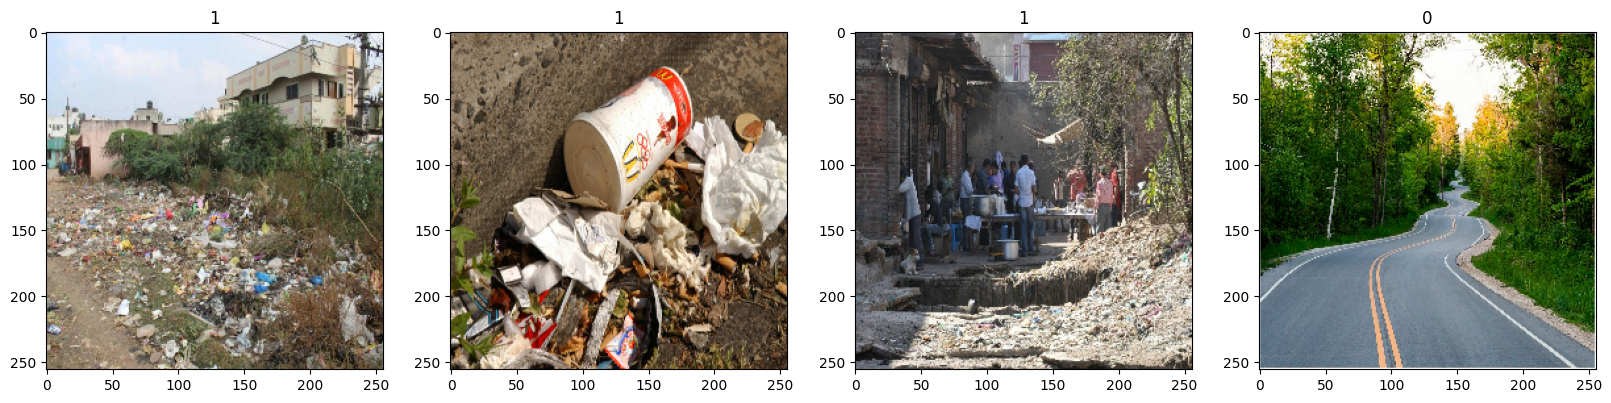

In [40]:
#this is one way too see wich classes belong 0 and 1
# 1 is dirty
# 0 is clean
# we can see that the images have the same size
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])


# Preprocess Data
Divide all the data to get the smallest values

In [ ]:
# scale data so we can read faster from the disk all the data
# all the images are between 0 and 1
data = data.map(lambda x,y: (x/255, y))

data.as_numpy_iterator().next()[0].max()

In [44]:
tam_data = len(data) #== 7
train_size = int(tam_data*0.7) #4 batch for train
val_size = int(tam_data*0.2)+1 #1 batch for validation
test_size = int(tam_data*0.1)+1 #1 batch for testing

In [45]:
#this will take the batches for each step of the model
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)


# Deep Model


In [52]:
model = Sequential()

#this one have 16 filters and the filter have 3x3 pixels
# and move one pixel each time

#with relu activation any output below 0 is converted to 0 and preseved the positive value
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(15, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))

#sigmoid reshape the output to a better result
#have one single layer at final
# convert the output to 0 or 1
# 1 - dirty
# 0 - clean
model.add(Dense(1, activation='sigmoid'))

In [53]:
#adam - optmizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#to see all the layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 15)        4335      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 15)       

### Train

In [54]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
4/4 [==============================] - 15s 3s/step - loss: 1.4258 - accuracy: 0.5938 - val_loss: 1.0357 - val_accuracy: 0.4844
Epoch 2/20
4/4 [==============================] - 13s 3s/step - loss: 0.8418 - accuracy: 0.4609 - val_loss: 0.6793 - val_accuracy: 0.7344
Epoch 3/20
4/4 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.6094

KeyboardInterrupt: ignored